
Here a machine learning model illustrating quantum machine learning is presented. It is called variational classifier.
A variational classifier is a type of quantum machine learning model that leverages variational quantum circuits to classify data. The key concepts are:

### 1. **Variational Quantum Circuits (VQC)**
Variational quantum circuits are quantum circuits with parameters that can be optimized. These circuits typically consist of a combination of quantum gates whose parameters (angles, displacements, etc.) are adjusted to minimize a cost function. 

### 2. **Encoding Data**
In a variational classifier, classical data is encoded into quantum states. This step transforms classical data into a quantum format that can be processed by the quantum circuit. This encoding can be done using various techniques, such as amplitude encoding or basis encoding.

### 3. **Quantum Circuit**
The encoded data is processed through a variational quantum circuit. The circuit applies a series of quantum gates, whose parameters are adjusted during training. The goal is to learn a quantum representation that captures the underlying patterns in the data.

### 4. **Cost Function and Optimization**
The output of the quantum circuit is used to compute a cost function, which quantifies how well the model's predictions match the true labels. The cost function is minimized by adjusting the parameters of the quantum circuit using classical optimization techniques, such as gradient descent or Adam.

### 5. **Prediction**
After training, the optimized quantum circuit can be used to classify new data. The final layer of the circuit often produces probabilities or other forms of predictions that are interpreted to make a classification decision.

### Example Workflow of a Variational Classifier

1. **Data Encoding:** Convert classical data into quantum states.
2. **Variational Quantum Circuit:** Process the quantum states through a parameterized quantum circuit.
3. **Measurement:** Measure the quantum state to obtain a prediction.
4. **Cost Function:** Compute a cost function based on the prediction and true labels.
5. **Optimization:** Adjust the circuit parameters to minimize the cost function.
6. **Prediction:** Use the trained quantum circuit to classify new data.

### Advantages and Challenges

- **Advantages:**
  - **Potential for High Expressiveness:** Quantum circuits can represent complex functions that might be hard for classical models.
  - **Quantum Speedups:** Certain quantum algorithms might offer advantages in specific cases.

- **Challenges:**
  - **Noisy Intermediate-Scale Quantum (NISQ) Devices:** Current quantum computers are noisy and have limited qubits, which can affect performance.
  - **Optimization Difficulties:** The optimization landscape for variational circuits can be complex, with many local minima.

In summary, variational classifiers use quantum circuits to perform classification tasks, leveraging the unique properties of quantum computing to potentially gain advantages in learning complex patterns.

The tutorial includes two key examples:

## Fitting the Parity Function:

This example shows how to train a quantum circuit to mimic the parity function, which determines whether the number of ones in a binary string is even or odd. The binary input is encoded into the initial state of the quantum circuit using computational basis states. The quantum circuit uses four qubits and includes arbitrary rotations and entangling CNOT gates. The BasisState function in PennyLane helps encode the bitstring into the quantum state.

## Classifying Iris Data:

This example demonstrates how to use amplitude encoding for real-valued vectors. The input data, such as the Iris dataset, is encoded into quantum states with amplitude encoding, and the variational circuit is trained to classify different flower species

## 1. Fitting the parity function

In [18]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [19]:
#We then create a quantum device that will run our circuits.

dev = qml.device("default.qubit",wires=4)


Variational classifiers often employ a "layer" or "block," which is a fundamental circuit design that is repeated to form the complete variational circuit. In our implementation, each layer uses four qubits (or wires), with each qubit undergoing an arbitrary rotation and being entangled with its neighboring qubit via a ring of CNOT gates. In machine learning terminology, we refer to the parameters of this layer as weights.

In [20]:
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

We also need a method to encode data inputs \(x\) into the circuit so that the measured output reflects these inputs. In this example, the inputs are bitstrings, which we encode into the qubits' state. After state preparation, the quantum state \(|\psi\rangle\) is a computational basis state with 1s where \(x\) has 1s. For example, if (\(x = 0101\), then |psi> = |0101>).

The PennyLane function `BasisState` is designed for this purpose, taking \(x\) as a list of zeros and ones, such as [0, 1, 0, 1].

In [21]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

In [22]:
#Now we define the variational quantum circuit as this state preparation routine, followed by a repetition of the layer structure.

@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [23]:
#If we want to add a “classical” bias parameter, the variational quantum classifier also needs some post-processing. We define the full model as a sum of the output of the quantum circuit, plus the trainable bias.

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

# Cost In supervised learning
The cost function is usually the sum of a loss function and a regularizer. We restrict ourselves to the standard square loss that measures the distance between target labels and model predictions.

In [24]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

To evaluate the performance of the current classifier, we use accuracy, which measures the fraction of predictions that align with the specified target labels.

In [25]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In machine learning tasks, the cost function is influenced by the data being used. Specifically, the cost is determined by the features and labels that are evaluated during each iteration of the optimization process. The cost reflects how well the model's predictions match the actual labels, guiding the optimization routine in adjusting the model parameters to improve accuracy.

In [26]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

### Optimization

Next, we need to load and preprocess the data to proceed with the optimization phase. 
The parity dataset, which includes both training and testing subsets, has been downloaded. These files are placed in the `variational_classifier/data` subfolder. This step is crucial as it organizes the data in the correct directory structure, enabling the subsequent processing and optimization steps to access and utilize the data effectively.

In [27]:
data = np.loadtxt("variational_classifier/data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


We begin by initializing the variables with random values, ensuring we set a fixed seed to maintain reproducibility of results. It is important to note that among these variables, one is designated as a bias term, while the remaining variables are utilized as parameters for the gates within the variational circuit. This initialization process sets the stage for training the model, as the choice of these variables will influence how the circuit learns and adapts during the optimization process.

In [28]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)



Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0


In [29]:
#Next we create an optimizer instance and choose a batch size…

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

We proceed to execute the optimizer to train our model. During this process, we monitor the model's performance by evaluating its accuracy, which represents the proportion of data samples that are correctly classified. To achieve this, we first compute the outputs generated by the variational classifier. We then convert these outputs into predictions within the set {−1, 1} by determining the sign of each output value. This transformation allows us to assess how well the classifier is performing in terms of accurate classification.

In [33]:
weights = weights_init
bias = bias_init

cost_history = []
tol = 1e-4  # Tolerance for convergence
prev_cost = float('inf')
current_cost = float('inf') 
verbose = 1  # Control verbosity: 0 = silent, 1 = progress bar, 2 = detailed output

for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    cost_history.append(current_cost)
    if abs(prev_cost - current_cost) < tol:  # Stopping condition based on tolerance
        if verbose:
            print(f"Converged at iteration {it} with cost {current_cost:.7f}")
        break
    prev_cost = current_cost
    if verbose == 1 and it % 20 == 0:  # Print cost every 20 iterations
        print("Iter: {:5d} | Cost: {:0.7f} ".format(it, current_cost))
    elif verbose == 2:
        print("Iter: {:5d} | Cost: {:0.7f} ".format(it, current_cost))

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:     0 | Cost: inf 
Iter:    1 | Cost: 2.9304456 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.3870566 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.3851591 | Accuracy: 0.5000000
Iter:    4 | Cost: 1.6096768 | Accuracy: 0.5000000
Iter:    5 | Cost: 1.3493458 | Accuracy: 0.5000000
Iter:    6 | Cost: 1.1105026 | Accuracy: 0.6000000
Iter:    7 | Cost: 0.9402790 | Accuracy: 0.6000000
Iter:    8 | Cost: 1.0201239 | Accuracy: 0.6000000
Iter:    9 | Cost: 1.3652730 | Accuracy: 0.8000000
Iter:   10 | Cost: 1.2442939 | Accuracy: 0.8000000
Iter:   11 | Cost: 1.8354873 | Accuracy: 0.6000000
Iter:   12 | Cost: 1.6407091 | Accuracy: 0.6000000
Iter:   13 | Cost: 1.6654484 | Accuracy: 0.8000000
Iter:   14 | Cost: 1.6854793 | Accuracy: 0.6000000
Iter:   15 | Cost: 1.8242424 | Accuracy: 0.4000000
Iter:   16 | Cost: 1.5191454 | Accuracy: 0.6000000
Iter:   17 | Cost: 1.2263851 | Accuracy: 0.6000000
Iter:   18 | Cost: 1.8539443 | Accuracy: 0.4000000
Iter:   19 | Cost: 1.2677376 | Accuracy: 0.6000000
Iter: 

The results show that the variational classifier has successfully learned to accurately classify all bit strings from the training set. However, in machine learning, the objective extends beyond simply optimizing the model on the training data; it is crucial to ensure that the model can generalize to new, unseen examples. This is where the concept of overfitting comes into play. Overfitting occurs when a model performs exceptionally well on the training data but fails to generalize effectively to new data. 

The challenge in (quantum) machine learning is to develop models and training procedures that avoid overfitting and instead find "good" minima—those that enable the model to generalize well to previously unseen examples. With this principle in mind, let us now evaluate the classifier's performance on a test set composed of examples that were not included during the training phase. This will help us assess how well the model generalizes to new data.

In [34]:
data = np.loadtxt("variational_classifier/data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0




The quantum circuit has also learnt to predict all unseen examples perfectly well! This is actually remarkable, since the encoding strategy creates quantum states from the data that have zero overlap – and hence the states created from the test set have no overlap with the states created from the training set. There are many functional relations the variational circuit could learn from this kind of representation, but the classifier chooses to label bit strings according to our ground truth, the parity function.

Let’s look at the second example, in which we use another encoding strategy.

The quantum circuit has demonstrated an impressive ability to accurately predict all unseen examples, which is particularly noteworthy given the encoding strategy used. This approach generates quantum states from the data with zero overlap, meaning that the states corresponding to the test set are entirely distinct from those associated with the training set. Despite the potential for numerous functional relations that the variational circuit could learn from such a representation, the classifier consistently aligns its predictions with the parity function, adhering to our ground truth.

Now, we will transition to a different encoding strategy using a new example. Specifically, we will classify data points from the Iris dataset. Unlike the simple bitstrings used previously, the Iris dataset consists of real-valued vectors. These vectors are two-dimensional, but we will enhance our representation by introducing additional "latent dimensions," encoding the inputs into two qubits.

State preparation in this context is more complex compared to representing a bitstring with a basis state. Each input vector \(x\) must be transformed into a set of angles suitable for feeding into the state preparation routine. To simplify the process, we will work within the positive subspace of the data, thereby omitting the need to handle sign changes that would otherwise require additional rotations around the Z-axis.

In [35]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [36]:
#Let’s test if this routine actually works.

x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.        0.        0.        0.795036  0.        0.
  0.        0.278265  0.        0.        0.       -0.        0.
  0.        0.      ]


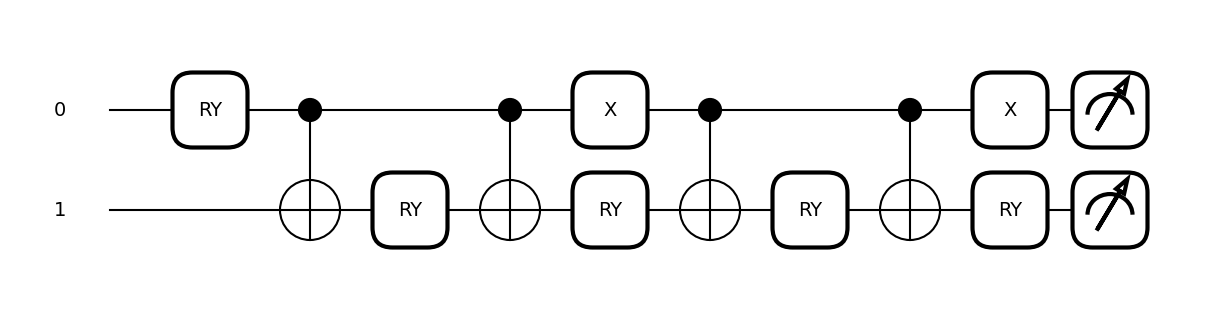

In [38]:
# Draw the circuit
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(test)(np.random.randn(5 , 4  ))
#plt.show()

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]

This has successfully calculated the precise angles needed to prepare the desired quantum state, demonstrating effective state preparation. In the `default.qubit` simulator, we can use the command `qml.StatePrep(x, wires=[0, 1])` to streamline the state preparation process. This command replaces the quantum state with the normalized input specified by `x`. While this shortcut is efficient on state simulators, on actual quantum hardware, the equivalent operation involves more complex procedures that implement state preparation with greater precision and sophistication.

As we are now working with a system of only two qubits, it is necessary to adjust our approach. Specifically, we need to update the layer function to accommodate the reduced qubit count. Additionally, we will redefine the cost function to handle the entire batch of data in a more effective manner. This involves adapting the cost function to process all data points simultaneously, akin to how NumPy broadcasting works. By applying this technique, we ensure that the state preparation routine can handle batches of data efficiently, applying the necessary transformations across all input vectors in parallel. This adjustment enhances computational efficiency and allows for more effective handling of data in the quantum circuit.

In [39]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])


def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

**Data Preprocessing**

We begin by loading the Iris dataset, which requires several preprocessing steps to prepare it for quantum computation. Our goal is to encode the input data into the amplitudes of a quantum state. 

Firstly, we augment the Iris data points by adding two so-called "latent dimensions." This step adjusts the size of each data point to match the dimensions of the state vector used by our quantum device. This augmentation is crucial because it ensures that the data can be accurately represented within the quantum computational framework.

Next, we need to normalize the data points. Normalization is essential to ensure that all data features contribute equally to the quantum state preparation and to prevent any single feature from disproportionately influencing the quantum state. Without normalization, the relative lengths of the vectors could distort the information, making it difficult for the quantum classifier to learn effectively.

Finally, we translate the preprocessed data into rotation angles using the `get_angles` function we previously defined. This function converts the normalized data points into a format suitable for quantum state preparation, mapping them into the angles required for the quantum rotations.

It is important to tailor the data preprocessing steps to the specific requirements of the problem at hand. For example, if we were to skip adding latent dimensions, normalization would eliminate information about the vector lengths, leading to indistinguishable classes that are separated by this feature.
The Iris dataset has been downloaded placed in the subfolder `variational_classifier/data` for proper access and use in the preprocessing pipeline.

In [40]:
data = np.loadtxt("variational_classifier/data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


The rotation angles derived from the `get_angles` function now serve as our new feature set, which is why we have updated the variable name from `X` to `features` in our processing pipeline. These angles effectively represent the input data in a format suitable for quantum computation, replacing the original data points with values that can be directly used for quantum state preparation.

To better understand the impact of these new features, we should visualize the stages of preprocessing. By plotting the data in different dimensions (dim1 and dim2), we can observe how well these dimensions separate the classes. Each pair of dimensions offers a different perspective on the data:

- **Well-Separated Classes**: Some dimensional pairs will clearly differentiate between classes, providing meaningful insights and contributing to effective classification.
- **Less Informative Dimensions**: Other pairs may not separate the classes as effectively, indicating that these dimensions offer less information for the classification task.

By experimenting with various dimensional combinations and analyzing the plots, we can identify which features are most informative for our quantum classifier and adjust our preprocessing steps accordingly to optimize the performance of our quantum model.

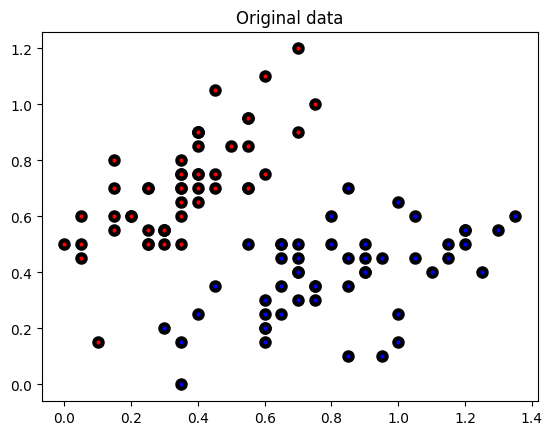

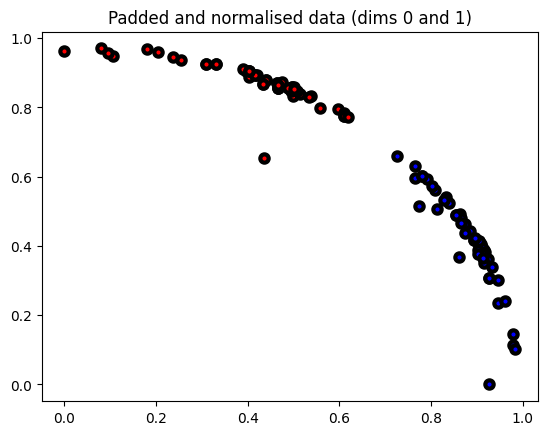

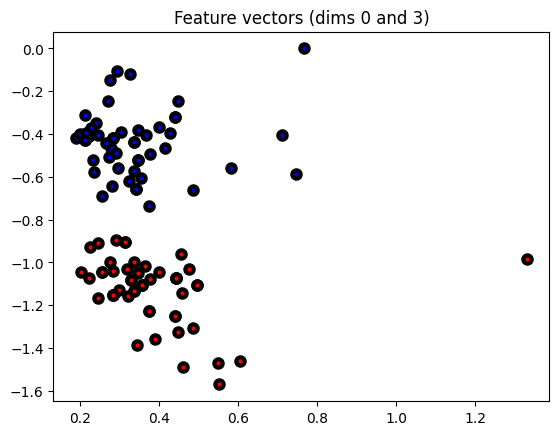

In [41]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

In this instance, our goal is to develop a model that generalizes well from the data samples, which involves training the model on one subset of the data and then evaluating its performance on a separate subset that was not used during the training process. This approach helps ensure that the model can accurately predict outcomes for new, unseen data, rather than just memorizing the training examples.

To effectively monitor and assess the generalization performance, the data is divided into two distinct sets: a training set and a validation set. 

- **Training Set**: This subset is used to train the model, where the model learns the underlying patterns and relationships within the data. The training process involves adjusting the model's parameters to minimize the error on this subset.

- **Validation Set**: This separate subset is not used during the training phase but is reserved for testing how well the trained model performs on new, unseen data. By evaluating the model's predictions on this validation set, we can gauge its ability to generalize and ensure that it is not overfitting to the training data.

This separation allows us to monitor the model's performance more accurately and make adjustments as necessary to improve its ability to generalize from the data, leading to better predictive accuracy on real-world, unseen examples.

In [42]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

## **Optimization**:

The optimization process begins with the initialization of variables. Here’s a detailed explanation of the steps involved:

1. **Variable Initialization**: Before training begins, we need to set up the initial values of the parameters that will be adjusted during the optimization process. These variables are crucial because their starting values can influence the effectiveness of the optimization and the final performance of the model.

2. **Random Initialization**: Typically, these variables are initialized randomly within a small range. Random initialization helps in breaking symmetry and allows the optimization algorithm to explore a broader range of parameter space. To ensure that experiments are reproducible, a random seed is set before initialization. This seed ensures that every run of the code produces the same initial values, allowing for consistent results and easier debugging.

3. **Types of Variables**: In the context of variational classifiers or quantum machine learning models, these variables often include parameters for quantum gates or layers. For instance, parameters might include rotation angles, displacement values, or other parameters that define the quantum circuit's behavior. Some variables may also serve as biases within the model.

4. **Impact of Initialization**: The choice of initial values can affect how quickly and effectively the optimization converges to an optimal solution. Poor initialization might lead to slower convergence or getting stuck in suboptimal solutions, whereas well-chosen initial values can facilitate faster convergence.

5. **Further Steps**: Once initialized, these variables will be iteratively updated by the optimization algorithm. The goal is to adjust them in such a way that the model's performance, as measured by a cost function, improves over time. The optimization process involves calculating gradients, applying updates, and repeating this process until the model reaches an acceptable level of performance.

Overall, the initialization of variables is a foundational step in the optimization process, setting the stage for effective training and fine-tuning of the model.

In [43]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [44]:
#Again we minimize the cost, using the imported optimizer.

opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.6589456 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.2054273 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 0.9740740 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:     8 | Cost: 0.9660872 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    10 | Cost: 0.9569019 | Acc train: 0.6000000 | Acc validation: 0.6000000
Iter:    12 | Cost: 0.9445863 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:    14 | Cost: 1.0339978 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    16 | Cost: 1.0774217 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:    18 | Cost: 0.9984426 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    20 | Cost: 0.8975279 | Acc train: 0.5600000 | Acc validation: 0.7600000
Iter:    22 | Cost: 0.8451699 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    24 | Cost: 0.8337489 | Acc train: 0.5600000 | Acc validation: 0.5200000
Iter:    26 | Cost: 0.783202

To better understand the performance and behavior of our variational classifier, we can visualize its continuous output by plotting it against the first two dimensions of the Iris dataset. This involves several steps:

1. **Extracting Dimensions**: We first select the first two dimensions from the Iris dataset, which are typically the sepal length and sepal width. These dimensions provide a straightforward way to visualize the data in a two-dimensional space.

2. **Generating Classifier Output**: For each data point in these two dimensions, we compute the output of the variational classifier. The classifier’s output is continuous, representing the predicted probability or score associated with each data point.

3. **Creating the Plot**: Using plotting tools such as matplotlib, we create a 2D plot where the x and y axes correspond to the first and second dimensions of the data, respectively. The color or intensity of each point in the plot represents the classifier’s output for that point. This visualization helps us see how the classifier’s predictions vary across the input space.

4. **Interpreting Results**: By examining this plot, we can gain insights into the decision boundaries or regions where the classifier assigns higher or lower values. This visualization can reveal how well the classifier differentiates between different classes based on the first two dimensions of the Iris data.

By plotting the continuous output of the variational classifier in this manner, we can better understand its performance, identify any potential areas for improvement, and assess how effectively it maps the input dimensions to the predicted outputs.

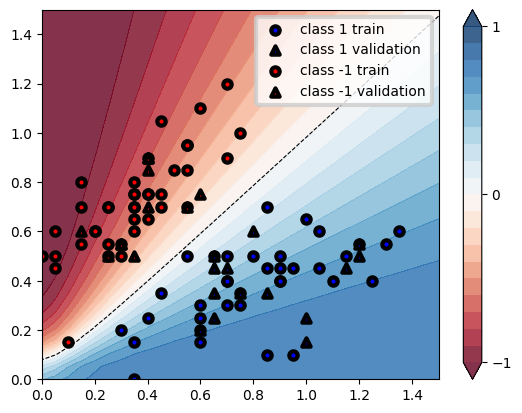

In [45]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()

The variational classifier has successfully learned a decision boundary that effectively separates the data points of the two different classes in the Iris dataset. Here’s a detailed breakdown of the process and findings:

1. **Learning the Decision Boundary**: During training, the variational classifier adjusts its parameters to minimize classification errors. As a result, it identifies a decision boundary, which is essentially a line (or a more complex shape in higher dimensions) that distinguishes between the two classes based on the input features.

2. **Visualization of the Decision Boundary**: By plotting the classifier's predictions against the input dimensions, we can visualize how well the classifier has learned to separate the two classes. The separating line found by the classifier reflects the regions of the input space where it predicts one class versus another.

3. **Validation Accuracy**: After training, the model is tested on unseen validation data to evaluate its generalization performance. The fact that the classifier achieves perfect accuracy on this validation set indicates that the learned decision boundary generalizes well to new, previously unseen examples. This is a strong indicator that the classifier has not only learned the training data but also correctly applied this knowledge to the validation set.

4. **Implications**: The successful classification of validation data implies that the variational classifier has effectively captured the underlying patterns of the data. It demonstrates the model's ability to generalize from the training set to new data, which is a key objective in machine learning.

Overall, the variational classifier’s ability to learn a clear separating line and achieve perfect accuracy on the validation set underscores its effectiveness in classifying the Iris dataset and suggests that it has successfully managed to extract relevant features and make accurate predictions.